In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv


In [2]:
print(os.listdir("../input/dogs-vs-cats-redux-kernels-edition/"))

['test.zip', 'train.zip', 'sample_submission.csv']


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
!unzip -q ../input/dogs-vs-cats-redux-kernels-edition/train.zip

In [5]:
!unzip -q ../input/dogs-vs-cats-redux-kernels-edition/test.zip

In [6]:
filenames = os.listdir("/kaggle/working/test")
for filename in filenames:
    test_df = pd.DataFrame({
    'filename': filenames
})

test_df.index = test_df.index + 1
test_df.head()

,filename
1,8607.jpg
2,9744.jpg
3,2043.jpg
4,12487.jpg
5,1687.jpg


In [7]:
print(os.listdir("/kaggle/working"))

['train', '__notebook__.ipynb', 'test']


In [8]:
filenames = os.listdir("/kaggle/working/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.7835.jpg,0
1,dog.169.jpg,1
2,cat.11153.jpg,0
3,cat.9278.jpg,0
4,dog.1713.jpg,1


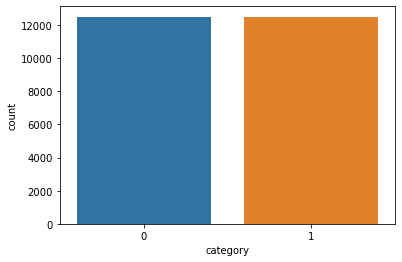

In [9]:
sns.countplot(df['category'])

In [10]:
df['category'] = df['category'].astype(str)

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [13]:
print(total_train)
print(total_validate)

22500
2500


In [14]:
train_batches = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1) \
    .flow_from_dataframe(
    train_df, 
    "/kaggle/working/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=124)

valid_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_dataframe(
    validate_df, 
    "/kaggle/working/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=124)

test_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_dataframe(
    test_df, 
    "/kaggle/working/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=124,
    target_size=(224, 224),
    shuffle=False
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [15]:
assert train_batches.n == 22500
assert valid_batches.n == 2500

In [16]:
imgs, labels = next(train_batches)

In [17]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

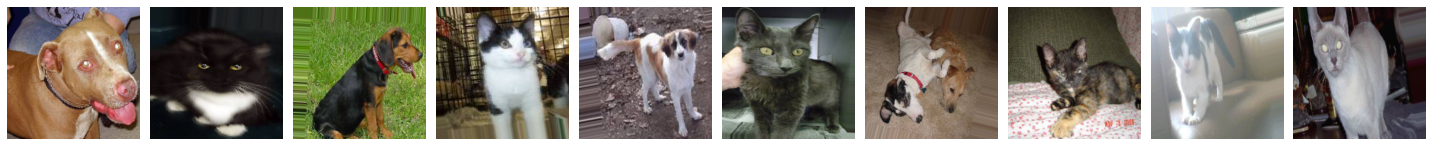

[1. 0. 1. 0. 1. 0. 1. 0. 0. 0.]


In [18]:
plotImages(imgs)
print(labels[0:10])

In [19]:
model= tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape = (224,224,3)),
     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
     tf.keras.layers.MaxPooling2D(2, 2),
     tf.keras.layers.Dropout(.25),
     tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')]
)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=2,
          verbose=2
)

Epoch 1/2
182/182 - 344s - loss: 0.6734 - accuracy: 0.5904 - val_loss: 0.6204 - val_accuracy: 0.6984
Epoch 2/2
182/182 - 332s - loss: 0.5923 - accuracy: 0.6782 - val_loss: 0.5587 - val_accuracy: 0.7304


Since accuracy is not that great, we will use a pre-trained model with transfer learning.

In [23]:
train_batches1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_dataframe(
    train_df, 
    "/kaggle/working/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=124)

valid_batches1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_dataframe(
    validate_df, 
    "/kaggle/working/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=124)

test_batches1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_dataframe(
    test_df, 
    "/kaggle/working/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=124,
    target_size=(224, 224),
    shuffle=False
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


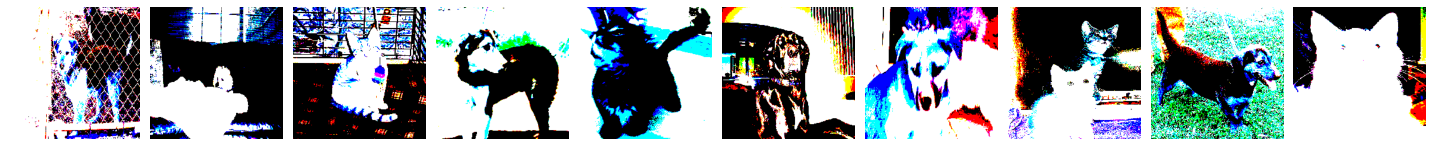

[1. 1. 0. 1. 0. 1. 1. 0. 1. 0.]


In [24]:
imgs, labels = next(train_batches1)
plotImages(imgs)
print(labels[0:10])

In [25]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 5s 0us/step


In [26]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Removing the Last Layer

In [27]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [29]:
for layer in model.layers:
    layer.trainable = False

In [30]:
model.add(Dense(units=1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model.fit(x=train_batches1,
          steps_per_epoch=len(train_batches1),
          validation_data=valid_batches1,
          validation_steps=len(valid_batches1),
          epochs=3,
          verbose=2)

Epoch 1/3
182/182 - 114s - loss: 0.2074 - accuracy: 0.9144 - val_loss: 0.0748 - val_accuracy: 0.9764
Epoch 2/3
182/182 - 112s - loss: 0.0647 - accuracy: 0.9785 - val_loss: 0.0541 - val_accuracy: 0.9800
Epoch 3/3
182/182 - 111s - loss: 0.0519 - accuracy: 0.9826 - val_loss: 0.0470 - val_accuracy: 0.9832


Predict

In [34]:
results = model.predict(test_batches)

In [35]:
test_df['category'] = np.where(results > 0.5, 1,0)

Submission

In [36]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)
